# Importing Libraries

In [1]:
from fitizens_libraries.load_and_process_training_data import load_training_data
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *

KeyboardInterrupt: 

# Creating Auxiliary Functions
### Min Max Paper: [Evaluating squat performance with a single inertial measurement unit](https://drive.google.com/file/d/1E2-rFIW66C2mi87BNUPmUFCgFs8VFoRs/view?usp=sharing)
### Descriptive Statistics Paper [Technology in Rehabilitation: Evaluating the Single Leg Squat Exercise with Wearable Inertial Measurement Units](https://drive.google.com/file/d/1OsCXUDf5jiAYZUt5Wwcr00iw7utEVx38/view)
### Traditional vs DeepLearning Paper: [Automatic Classification of Squat Posture Using Inertial Sensors: Deep Learning Approach](https://www.mdpi.com/1424-8220/20/2/361)

In [ ]:
def create_custom_dataframe(series):
    df =  series[["linAccX", "linAccY", "linAccZ", "gyroX", "gyroY", "gyroZ", "magnX", "magnY", "magnZ"]]
    return df

In [ ]:
def create_training_data_min_max(df, target):
    stats_dict = {}

    series = create_custom_dataframe(df)
    for column in series.columns:
        max_value = series[column].max()
        min_value = series[column].min()
        range_value = max_value - min_value
    
        stats_dict[f"{column}_max"] = max_value
        stats_dict[f"{column}_min"] = min_value
        stats_dict[f"{column}_range"] = range_value
        
    stats_dict["target"] = target
    return stats_dict

In [ ]:


def create_training_data_mean_std_med(df, target):
    stats_dict = {}

    series = create_custom_dataframe(df)
    for column in series.columns:
        mean = series[column].mean()
        std = series[column].std()
        median = series[column].median()
    
        stats_dict[f"{column}_mean"] = mean
        stats_dict[f"{column}_std"] = std
        stats_dict[f"{column}_median"] = median
        
    stats_dict["target"] = target
    return stats_dict

# Loading Data

In [ ]:
folder_path = "labeled"
os.makedirs(folder_path, exist_ok=True)
file_names = [f"{folder_path}/{name}" for name in os.listdir(folder_path)]
signals = ["accX", "accY", "accZ", "gyroX", "gyroY", "gyroZ", "magnX", "magnY", "magnZ", "linAccX", "linAccY", "linAccZ"]

data, wk = load_training_data(filelist=file_names,
                         signals= signals,
                          target_exercise="SQUAT", other_exercises=[], is_peak_minima=True)
data[0]

{'series':                          accX_orig  accY_orig  accZ_orig  gyroX_orig  \
 time                                                                   
 1970-01-01 00:00:00.474   0.160325   3.283070  -0.118723  125.159996   
 1970-01-01 00:00:00.483   0.205790   3.405108  -0.348442  129.080002   
 1970-01-01 00:00:00.492   0.198611   3.503217  -0.659520  128.169998   
 1970-01-01 00:00:00.501   0.126824   3.316570  -0.793523  127.049995   
 1970-01-01 00:00:00.510   0.050251   3.295034  -0.860524  129.220001   
 ...                            ...        ...        ...         ...   
 1970-01-01 00:00:01.531  -0.172289   4.699671  -1.432429  -87.920006   
 1970-01-01 00:00:01.540  -0.212969   4.572847  -1.418072  -82.880005   
 1970-01-01 00:00:01.549  -0.222540   4.632670  -1.456358  -80.010002   
 1970-01-01 00:00:01.558  -0.354150   4.661385  -1.987584  -79.730003   
 1970-01-01 00:00:01.567  -0.495332   4.312020  -2.102443  -79.520004   
 
                          gyroY_orig  g

# Creating new data

In [ ]:
data_info = [create_training_data_mean_std_med(info["series"], info["target"]) for info in data]
data_custom = pd.DataFrame(data_info)
data_custom.head()

,linAccX_mean,linAccX_std,linAccX_median,linAccY_mean,linAccY_std,linAccY_median,linAccZ_mean,linAccZ_std,linAccZ_median,gyroX_mean,...,magnX_mean,magnX_std,magnX_median,magnY_mean,magnY_std,magnY_median,magnZ_mean,magnZ_std,magnZ_median,target
0,0.475693,0.444189,0.604449,-0.064382,0.201904,-0.017634,1.084862,3.311060,1.841822,6.446957,...,113.922673,1.511774,113.740783,105.645760,1.579641,106.327918,162.709051,8.196471,164.514308,SQUAT
1,0.436280,0.485130,0.641912,0.050774,0.227051,0.083403,0.956848,2.846323,1.384450,0.362799,...,113.810630,1.261197,113.589972,105.646582,1.241413,106.177881,164.105538,8.303264,165.637205,SQUAT
2,0.457903,0.470508,0.604933,0.078159,0.160814,0.123268,1.098518,3.173660,2.082821,6.661235,...,113.426752,1.120535,112.962573,105.811957,0.993088,106.015616,165.059245,7.472576,166.777286,SQUAT
3,0.504729,0.509760,0.719400,0.059016,0.133882,0.035024,1.127450,3.123841,2.709761,2.916382,...,113.179327,1.466456,112.808564,104.957545,1.209527,105.155497,170.951369,9.970589,173.638573,SQUAT
4,0.470926,0.481927,0.688152,0.058959,0.174069,0.108836,0.974739,2.707455,1.910544,3.956676,...,112.578127,1.332054,112.138872,105.100280,1.191062,105.369625,171.290676,9.659595,173.157878,SQUAT


# EDA

In [ ]:
data_custom.shape

(3805, 28)

In [ ]:
data_custom.isnull().sum()

linAccX_mean      0
linAccX_std       0
linAccX_median    0
linAccY_mean      0
linAccY_std       0
linAccY_median    0
linAccZ_mean      0
linAccZ_std       0
linAccZ_median    0
gyroX_mean        0
gyroX_std         0
gyroX_median      0
gyroY_mean        0
gyroY_std         0
gyroY_median      0
gyroZ_mean        0
gyroZ_std         0
gyroZ_median      0
magnX_mean        0
magnX_std         0
magnX_median      0
magnY_mean        0
magnY_std         0
magnY_median      0
magnZ_mean        0
magnZ_std         0
magnZ_median      0
target            0
dtype: int64

In [ ]:
data_custom.target.value_counts()

NO_EXERCISE    2934
SQUAT           871
Name: target, dtype: int64

In [ ]:
corr_matrix = data_custom.drop(columns=["target"],axis=1).corr()
corr_matrix

,linAccX_mean,linAccX_std,linAccX_median,linAccY_mean,linAccY_std,linAccY_median,linAccZ_mean,linAccZ_std,linAccZ_median,gyroX_mean,...,gyroZ_median,magnX_mean,magnX_std,magnX_median,magnY_mean,magnY_std,magnY_median,magnZ_mean,magnZ_std,magnZ_median
linAccX_mean,1.000000,0.267910,0.929875,-0.124820,0.129302,-0.085521,0.165985,0.187726,-0.020827,0.084000,...,-0.053135,0.331287,0.082072,0.331258,-0.362442,0.096580,-0.362304,-0.346230,0.268137,-0.345802
linAccX_std,0.267910,1.000000,0.191259,-0.023712,0.478183,0.007377,0.361370,0.741789,-0.077939,0.066260,...,-0.114224,-0.021624,0.227731,-0.022071,-0.203908,0.477396,-0.202285,-0.163649,0.716838,-0.160899
linAccX_median,0.929875,0.191259,1.000000,-0.066135,0.100208,-0.036918,0.110114,0.142920,-0.023503,0.060410,...,-0.042637,0.302138,0.044812,0.302002,-0.292529,0.069346,-0.292756,-0.278216,0.186324,-0.278282
linAccY_mean,-0.124820,-0.023712,-0.066135,1.000000,0.276665,0.935889,-0.010509,0.065271,0.001835,0.041686,...,0.122687,-0.225959,-0.079468,-0.225684,0.299457,-0.056518,0.299189,0.240243,-0.007339,0.240636
linAccY_std,0.129302,0.478183,0.100208,0.276665,1.000000,0.333029,0.174184,0.412838,-0.130813,0.019426,...,0.073817,-0.101591,0.194901,-0.101823,-0.276009,0.138313,-0.275474,-0.204827,0.309819,-0.203563
linAccY_median,-0.085521,0.007377,-0.036918,0.935889,0.333029,1.000000,0.008870,0.103984,-0.036008,0.048211,...,0.124949,-0.225768,-0.051709,-0.225509,0.223837,-0.035856,0.223658,0.181046,0.003858,0.181683
linAccZ_mean,0.165985,0.361370,0.110114,-0.010509,0.174184,0.008870,1.000000,0.446451,0.681651,0.168472,...,-0.024629,-0.114221,0.155685,-0.114558,-0.093583,0.078697,-0.093286,-0.072857,0.189524,-0.068729
linAccZ_std,0.187726,0.741789,0.142920,0.065271,0.412838,0.103984,0.446451,1.000000,-0.101211,0.099566,...,-0.117084,-0.267396,0.038601,-0.267372,-0.207354,0.518420,-0.205919,-0.214655,0.592923,-0.212039
linAccZ_median,-0.020827,-0.077939,-0.023503,0.001835,-0.130813,-0.036008,0.681651,-0.101211,1.000000,0.072810,...,0.062325,0.066848,0.065121,0.066621,0.163356,-0.243517,0.162160,0.185786,-0.172259,0.187769
gyroX_mean,0.084000,0.066260,0.060410,0.041686,0.019426,0.048211,0.168472,0.099566,0.072810,1.000000,...,-0.199992,-0.036581,0.074107,-0.036677,-0.039455,0.010617,-0.039326,-0.043127,0.071509,-0.042170


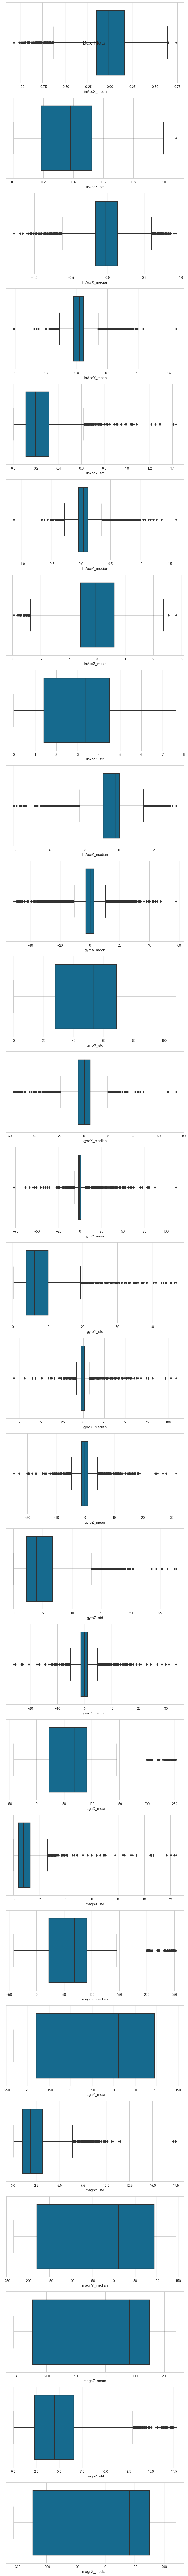

In [ ]:
# Create a figure and a set of subplots
df_box = data_custom.drop(columns=["target"],axis=1)
fig, axes = plt.subplots(nrows=len(df_box.columns), ncols=1, figsize=(8, 4 * len(df_box.columns)))

# Create a box plot for each column
for i, col in enumerate(df_box.columns):
    sns.boxplot(x=df_box[col], ax=axes[i])

# Add a title (optional)
fig.suptitle('Box Plots', fontsize=16)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# ML with Pycaret

In [ ]:
data_dev = data_custom.sample(frac=0.95, random_state=786)
data_prod = data_custom.drop(data_dev.index)

data_dev.reset_index(inplace=True, drop=True)
data_prod.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data_dev.shape))
print('Simulated data For Production ' + str(data_prod.shape))

Data for Modeling: (3615, 28)
Simulated data For Production (190, 28)


In [ ]:
model = setup(
    # Basic options
    data = data_dev,
    target = "target",
    train_size = 0.7,
    preprocess = True,
    
    # Dealing with multicollinearity
    remove_multicollinearity = True,
    multicollinearity_threshold = 0.9,
        
    # Feature normalization with outliers
    normalize = True,
    normalize_method = 'robust',
        
    # Paralellization options
    n_jobs = - 1,
    use_gpu = False,
    
    # Imbalance Dataset
    fix_imbalance=True,
    
    # Feature Importance
    feature_selection = True,
    n_features_to_select= 10
)

[LightGBM] [Info] Number of positive: 1960, number of negative: 1960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Description,Value
0,Session id,5859
1,Target,target
2,Target type,Binary
3,Target mapping,"NO_EXERCISE: 0, SQUAT: 1"
4,Original data shape,"(3615, 28)"
5,Transformed data shape,"(5005, 11)"
6,Transformed train set shape,"(3920, 11)"
7,Transformed test set shape,"(1085, 11)"
8,Numeric features,27
9,Preprocess,True


In [ ]:
models = compare_models(sort="F1", fold=2)
models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9964,0.9998,0.9912,0.9930,0.9921,0.9898,0.9898,1.1250
qda,Quadratic Discriminant Analysis,0.9957,0.9945,0.9842,0.9965,0.9903,0.9875,0.9875,10.3550
knn,K Neighbors Classifier,0.9929,0.9976,0.9930,0.9759,0.9843,0.9797,0.9798,5.2800
catboost,CatBoost Classifier,0.9925,0.9991,0.9789,0.9877,0.9832,0.9784,0.9785,6.2400
gbc,Gradient Boosting Classifier,0.9913,0.9987,0.9842,0.9776,0.9808,0.9752,0.9753,9.7700
lightgbm,Light Gradient Boosting Machine,0.9913,0.9993,0.9789,0.9825,0.9807,0.9750,0.9751,0.6750
rf,Random Forest Classifier,0.9913,0.9988,0.9737,0.9876,0.9806,0.9750,0.9750,9.7450
xgboost,Extreme Gradient Boosting,0.9905,0.9993,0.9772,0.9808,0.9789,0.9727,0.9729,1.5500
nb,Naive Bayes,0.9885,0.9966,0.9702,0.9791,0.9743,0.9669,0.9672,3.6250
ada,Ada Boost Classifier,0.9870,0.9965,0.9667,0.9753,0.9708,0.9624,0.9626,8.7850


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=5859, verbose=0, warm_start=False)

In [ ]:
cnt_models_df = pull()
cnt_models_df

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9964,0.9998,0.9912,0.9930,0.9921,0.9898,0.9898,1.125
qda,Quadratic Discriminant Analysis,0.9957,0.9945,0.9842,0.9965,0.9903,0.9875,0.9875,10.355
knn,K Neighbors Classifier,0.9929,0.9976,0.9930,0.9759,0.9843,0.9797,0.9798,5.280
catboost,CatBoost Classifier,0.9925,0.9991,0.9789,0.9877,0.9832,0.9784,0.9785,6.240
gbc,Gradient Boosting Classifier,0.9913,0.9987,0.9842,0.9776,0.9808,0.9752,0.9753,9.770
lightgbm,Light Gradient Boosting Machine,0.9913,0.9993,0.9789,0.9825,0.9807,0.9750,0.9751,0.675
rf,Random Forest Classifier,0.9913,0.9988,0.9737,0.9876,0.9806,0.9750,0.9750,9.745
xgboost,Extreme Gradient Boosting,0.9905,0.9993,0.9772,0.9808,0.9789,0.9727,0.9729,1.550
nb,Naive Bayes,0.9885,0.9966,0.9702,0.9791,0.9743,0.9669,0.9672,3.625
ada,Ada Boost Classifier,0.9870,0.9965,0.9667,0.9753,0.9708,0.9624,0.9626,8.785


In [ ]:
clf = create_model('et', fold = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9953,0.9998,0.9860,0.9929,0.9894,0.9864,0.9864
1,0.9968,1.0000,0.9965,0.9895,0.9930,0.9910,0.9910
Mean,0.9960,0.9999,0.9912,0.9912,0.9912,0.9887,0.9887
Std,0.0008,0.0001,0.0053,0.0017,0.0018,0.0023,0.0023


In [ ]:
tuned_clf = tune_model(clf, optimize = 'F1', fold = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9945,0.9972,0.9895,0.9860,0.9877,0.9842,0.9842
1,0.9960,0.9992,0.9965,0.9861,0.9913,0.9887,0.9887
Mean,0.9953,0.9982,0.9930,0.9861,0.9895,0.9864,0.9865
Std,0.0008,0.0010,0.0035,0.0000,0.0018,0.0023,0.0023


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
print("Total of features: ", len(tuned_clf.feature_importances_))

Total of features:  10


In [ ]:
evaluate_model(tuned_clf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Save Model

In [ ]:
# We finalize model (we train on the whole set)
model_final = finalize_model(tuned_clf)

In [ ]:
# Export the PyCaret model
save_model(model_final, 'squats_traditional')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['linAccX_mean', 'linAccX_std',
                                              'linAccX_median', 'linAccY_mean',
                                              'linAccY_std', 'linAccY_median',
                                              'linAccZ_mean', 'linAccZ_std',
                                              'linAccZ_median', 'g...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='sqrt',
                                       max_leaf_nodes=None, max_samples=No

# Use in Production

In [ ]:
# Load the model
pipeline = load_model(model_name="squats_traditional")

Transformation Pipeline and Model Successfully Loaded


In [ ]:
# Utilizar modelo
prediction = predict_model(pipeline, data_prod, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9895,0.9990,0.9895,0.9896,0.9894,0.9744,0.9747


In [ ]:
prediction

,linAccX_mean,linAccX_std,linAccX_median,linAccY_mean,linAccY_std,linAccY_median,linAccZ_mean,linAccZ_std,linAccZ_median,gyroX_mean,...,magnY_mean,magnY_std,magnY_median,magnZ_mean,magnZ_std,magnZ_median,target,prediction_label,prediction_score_NO_EXERCISE,prediction_score_SQUAT
0,0.456994,0.518119,0.687853,0.066211,0.215896,0.059534,1.113353,3.071915,2.007688,5.635071,...,105.812187,0.873874,106.042770,168.247589,8.481453,170.195312,1,SQUAT,0.00,1.00
1,0.435078,0.644106,0.572391,0.110318,0.220210,0.197128,1.467973,4.192334,2.386148,4.100727,...,105.466606,0.874662,105.614082,165.553940,7.889953,166.811584,1,SQUAT,0.00,1.00
2,0.525479,0.442871,0.755463,0.020423,0.335219,-0.047069,1.256029,3.565994,2.065840,9.831512,...,106.059235,1.067700,106.352402,165.745956,7.600916,167.895203,1,SQUAT,0.01,0.99
3,0.493536,0.571566,0.734685,0.097360,0.133087,0.102572,1.620815,4.524659,1.980033,7.395948,...,93.786972,3.855010,93.511917,179.875534,5.382401,181.272034,1,SQUAT,0.00,1.00
4,0.548302,0.711540,0.857918,0.115441,0.258424,0.172384,1.702348,4.793819,2.335813,3.928243,...,99.995186,1.975416,100.696365,182.228058,7.970673,184.134720,1,SQUAT,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,-0.162655,0.072352,-0.135040,-0.117529,0.050627,-0.111165,-0.315058,0.728846,0.038030,9.600480,...,21.342312,1.049078,21.747631,76.678307,1.537818,76.065926,0,NO_EXERCISE,1.00,0.00
186,-0.308690,0.378967,-0.436400,0.025977,0.124684,0.021165,-1.269073,2.083804,-0.498138,-43.719498,...,16.509968,3.180143,15.972856,84.777588,3.904512,85.575424,0,NO_EXERCISE,1.00,0.00
187,-0.459555,0.084026,-0.465768,0.106945,0.096869,0.116787,-1.517915,1.670327,-0.943461,-4.251428,...,20.088591,0.907426,20.575190,77.987129,1.112523,77.532272,0,NO_EXERCISE,1.00,0.00
188,-0.412204,0.189204,-0.355586,0.085288,0.097034,0.112778,-1.474884,1.752420,-0.730075,-2.537713,...,20.714251,0.558585,20.933205,78.182014,1.393809,77.444687,0,NO_EXERCISE,1.00,0.00


# Scores

In [ ]:
true_labels = prediction["target"]
predictions = prediction["prediction_label"]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
positive_class_label = "SQUAT"
precision = precision_score(true_labels, predictions, pos_label=positive_class_label)
recall = recall_score(true_labels, predictions, pos_label=positive_class_label)
f1 = f1_score(true_labels, predictions, pos_label=positive_class_label)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[0 1] and y_pred=['NO_EXERCISE' 'SQUAT']. Make sure that the predictions provided by the classifier coincides with the true labels.

In [ ]:
from sklearn.metrics import roc_auc_score

predictions_prob = prediction["prediction_score_SQUAT"]
binary_true_labels = true_labels.map({"SQUAT": 1, "NO_EXERCISE": 0})
auc_score = roc_auc_score(binary_true_labels, predictions_prob)

print(f"AUC: {auc_score}")